In [1]:
import cobra
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite

# Read model (model of Escherichia coli)
model = read_sbml_model('model_atocopherol.xml')

In [69]:
model.objective = model.reactions.DM_avite1_c

To get a better understanding of how to improve the production pathway, the associated reactions and fluxes are explored. The metabolite 3-(4-Hydroxyphenyl)pyruvate is the starting point for the heterologous pathway that was added to the model.

In [85]:
model.metabolites.get_by_id('34hpp_c')

Metabolite identifier,34hpp_c
Name,3-(4-Hydroxyphenyl)pyruvate
Memory address,0x07ff88828e4f0
Formula,C9H7O4
Compartment,c
In 3 reaction(s),"TYRTA, 34HPPOR, PPND"


3-(4-Hydroxyphenyl)pyruvate is part of three reactions. 34HPPOR is the first reaction of the heterologous pathway that consumes 3-(4-Hydroxyphenyl)pyruvate. Whereas TYRTA and PPND are reactions where 3-(4-Hydroxyphenyl)pyruvate is produced.

In [71]:
model.reactions.PPND

Reaction identifier,PPND
Name,Prephenate dehydrogenase
Memory address,0x07ff889913df0
Stoichiometry,nad_c + pphn_c --> 34hpp_c + co2_c + nadh_c Nicotinamide adenine dinucleotide + Prephenate --> 3-(4-Hydroxyphenyl)pyruvate + CO2 CO2 + Nicotinamide adenine dinucleotide - reduced
GPR,b2600
Lower bound,0.0
Upper bound,1000.0


In [86]:
model.reactions.TYRTA

Reaction identifier,TYRTA
Name,Tyrosine transaminase
Memory address,0x07ff88a2b7880
Stoichiometry,akg_c + tyr__L_c <=> 34hpp_c + glu__L_c 2-Oxoglutarate + L-Tyrosine <=> 3-(4-Hydroxyphenyl)pyruvate + L-Glutamate
GPR,b4054 or b0928 or b3770
Lower bound,-1000.0
Upper bound,1000.0


While exploring the fluxes, the production of biomass is set to half of the optimal production rate as a compromise between cell growth and production of alpha-tocopherol.

In [80]:
with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    solution = model.optimize()
print("EX_tyr__L_e", solution.fluxes.EX_tyr__L_e)
print("PPND", solution.fluxes.PPND)
print("TYRTA",solution.fluxes.TYRTA)
print("HGPHT",solution.fluxes.HGPHT)
print("TOCOPHOM1",solution.fluxes.TOCOPHOM1)
print("DM_avite1_c",solution.fluxes.DM_avite1_c)

EX_tyr__L_e 0.0
PPND 0.6741627607421248
TYRTA -0.06077236
HGPHT 0.6133904007421248
TOCOPHOM1 0.6133904007421248
DM_avite1_c 0.6133904007421248


In [58]:
with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    model.reactions.EX_tyr__L_e.lower_bound = -10
    solution = model.optimize()
print("EX_tyr__L_e", solution.fluxes.EX_tyr__L_e)
print("PPND", solution.fluxes.PPND)
print("TYRTA",solution.fluxes.TYRTA)
print("TOCOPHOM1",solution.fluxes.TOCOPHOM1)
print("DM_avite1_c",solution.fluxes.DM_avite1_c)

EX_tyr__L_e -0.8597443803366394
PPND 0.0
TYRTA 0.7989720203366394
TOCOPHOM1 0.7989720203366394
DM_avite1_c 0.7989720203366394


It is shown here that in the absence of exogenous tyrosine, 3-(4-Hydroxyphenyl)pyruvate is produced in reaction PPND while reaction TYRTA has a negative flux meaning that a part of the 3-(4-Hydroxyphenyl)pyruvate pool is consumed to produce tyrosine. When tyrosine is supplied in the medium, the reaction PPND does not carry any flux anymore. In this case, 3-(4-Hydroxyphenyl)pyruvate is produced from tyrosine in the reaction TYRTA.

The flux variability analysis shows the minimal and maximal flux that a reaction can carry.

In [87]:
from cobra.flux_analysis import flux_variability_analysis

with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    model.reactions.EX_tyr__L_e.lower_bound = -10
    reactions_OE = [model.reactions.EX_tyr__L_e, model.reactions.TYRTA, model.reactions.PPND, model.reactions.DM_avite1_c]
    fva = flux_variability_analysis(model, reaction_list = reactions_OE, fraction_of_optimum=0.9)
print(fva)

              minimum   maximum
EX_tyr__L_e -1.331703 -0.488684
TYRTA        0.427912  0.798973
PPND         0.000000  0.291163
DM_avite1_c  0.719075  0.798973


In [88]:
with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    model.reactions.EX_tyr__L_e.lower_bound = -10
    model.reactions.TYRTA.lower_bound = 0.8
    reactions_OE = [model.reactions.EX_tyr__L_e, model.reactions.TYRTA, model.reactions.PPND, model.reactions.DM_avite1_c]
    fva = flux_variability_analysis(model, reaction_list = reactions_OE, fraction_of_optimum=0.9)
print(fva)

Infeasible: There is no optimal solution for the chosen objective! (infeasible).

Changing the lower bound of TYRTA to 0.8 to enforce a higher flux proofed to be infeasible. 

In [89]:
# higher bounds
with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    model.reactions.EX_tyr__L_e.lower_bound = -10
    model.reactions.TYRTA.lower_bound = 0.7
    reactions_OE = [model.reactions.EX_tyr__L_e, model.reactions.TYRTA, model.reactions.PPND, model.reactions.DM_avite1_c]
    fva = flux_variability_analysis(model, reaction_list = reactions_OE, fraction_of_optimum=0.9)
print(fva)

              minimum   maximum
EX_tyr__L_e -1.331703 -0.760772
TYRTA        0.700000  0.798973
PPND         0.000000  0.077662
DM_avite1_c  0.719075  0.798973


Changing the lower bound of TYRTA to 0.7 to enforce a higher flux did not change the maximal flux of alpha-tocopherol production. 

### Flux Scanning Based On Enforced Objective Flux (FSEOF)

In order to find potential targets for overexpression, a Flux Scanning Based On Enforced Objective Flux was performed.

In [66]:
import cameo
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

In [67]:
fseof = FSEOF(model)

In [90]:
with model:
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.44
    model.reactions.EX_tyr__L_e.lower_bound = -10
    result = fseof.run(target=model.reactions.DM_avite1_c)
    df = result.data_frame
df

,1,2,3,4,5,6,7,8,9,10
SHK3Dr,0.106920,0.106920,0.106920,0.106920,0.107109,0.107937,0.108764,0.109591,0.110418,0.111246
DHORTS,-0.145550,-0.145550,-0.145550,-0.145550,-0.145807,-0.146934,-0.148060,-0.149186,-0.150312,-0.151438
OMPDC,0.145550,0.145550,0.145550,0.145550,0.145807,0.146934,0.148060,0.149186,0.150312,0.151438
G5SD,0.097264,0.097264,0.097264,0.097264,0.097436,0.098189,0.098942,0.099694,0.100447,0.101199
APRAUR,0.009262,0.018328,0.027393,0.036459,0.043977,0.046275,0.048573,0.050872,0.053170,0.055468
...,...,...,...,...,...,...,...,...,...,...
TYRL,0.000098,0.000098,0.000098,0.000098,0.000098,0.000099,0.000100,0.000101,0.000101,0.000102
THZPSN3,0.000098,0.000098,0.000098,0.000098,0.000098,0.000099,0.000100,0.000101,0.000101,0.000102
4HTHRK,0.000294,0.000294,0.000294,0.000294,0.000295,0.000297,0.000299,0.000302,0.000304,0.000306
BIOMASS_Ec_iML1515_core_75p37M,0.440000,0.440000,0.440000,0.440000,0.440779,0.444183,0.447588,0.450992,0.454397,0.457801


For some reason the rate of the target reaction DM_avite1_c goes down with every step and not up as it would be expected.

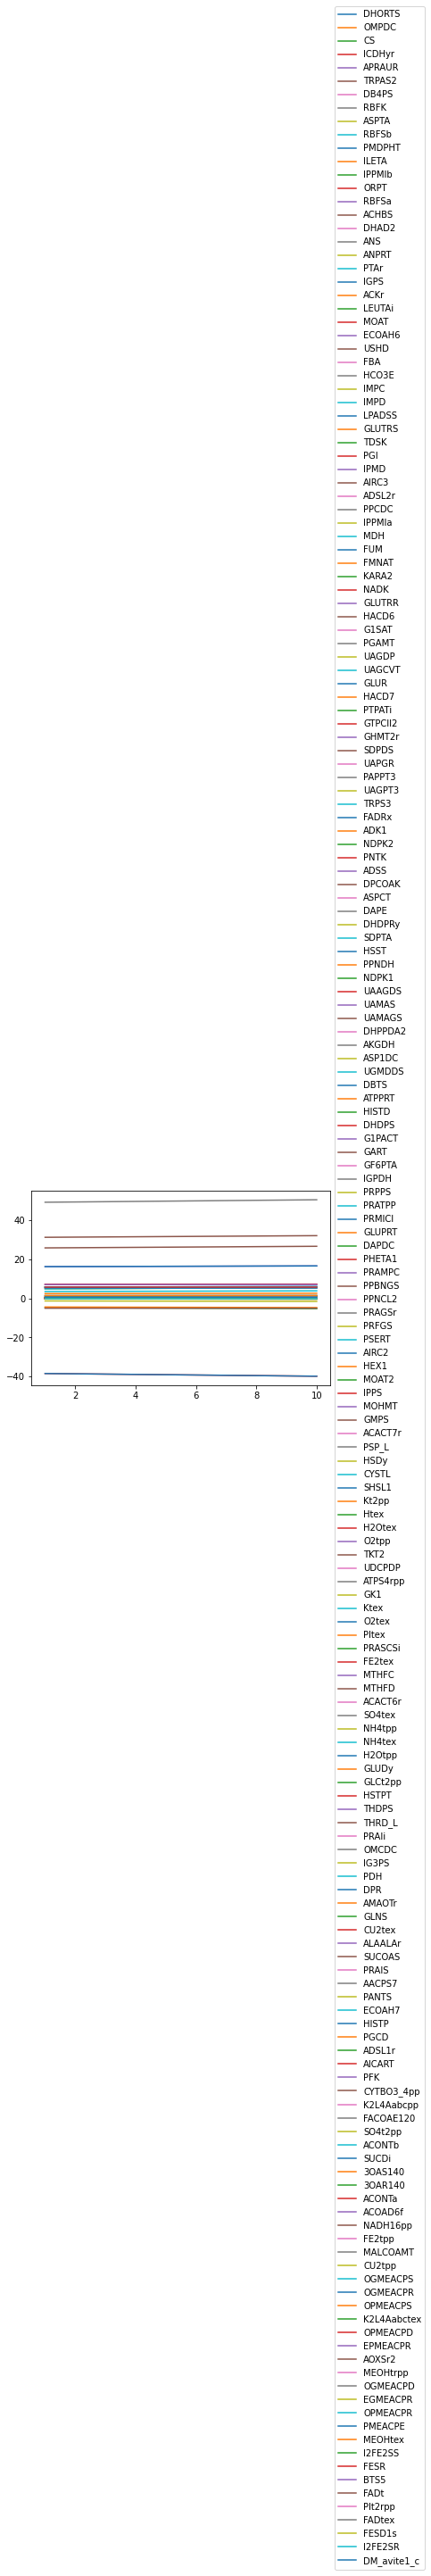

In [30]:
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
# sorting the dataframe
df= df.sort_values([1], ascending = False)
 
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]
df.head()

,1,2,3,4,5,6,7,8,9,10
ATPS4rpp,49.082201,49.222631,49.363060,49.503490,49.643920,49.784350,49.924780,50.065209,50.205639,50.346069
CYTBO3_4pp,31.180210,31.273343,31.366477,31.459611,31.552745,31.645878,31.739012,31.832146,31.925280,32.018413
NADH16pp,25.770314,25.861234,25.952154,26.043074,26.133994,26.224913,26.315833,26.406753,26.497673,26.588593
O2tex,16.199177,16.239610,16.280043,16.320476,16.360909,16.401342,16.441775,16.482208,16.522641,16.563074
O2tpp,16.199177,16.239610,16.280043,16.320476,16.360909,16.401342,16.441775,16.482208,16.522641,16.563074


ValueError: Invalid color ['red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue']

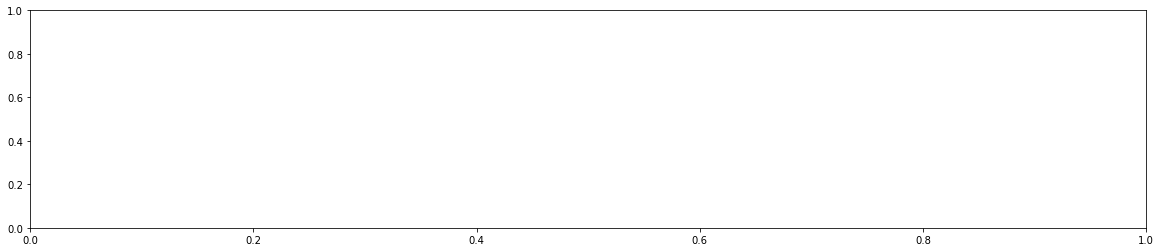

In [34]:
def bar_color(df,color1,color2):
    return np.where(df.values >=0,color1,color2).T

fig = df.plot(legend=None, kind='bar', color=bar_color(df,"red","blue"),figsize=(20, 4), grid =False);
fig.set_ylabel('Change in flux')
fig.set_xlabel('Gene names')
fig.set_title('Flux scanning based on Enforced Objective Flux', size=30)

In [35]:
df['relative_change_in_flux'] = (df[10]-df[1])/df[10] +1

In [36]:
target_reactions_df = df[df['relative_change_in_flux'] > 1.8]

In [37]:
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
GART,0.027633,0.054185,0.080737,0.107289,0.133841,0.160393,0.186944,0.213496,0.240048,0.266600,1.896350
DB4PS,0.018095,0.035796,0.053497,0.071199,0.088900,0.106601,0.124303,0.142004,0.159705,0.177406,1.898002
RBFSa,0.018095,0.035796,0.053497,0.071199,0.088900,0.106601,0.124303,0.142004,0.159705,0.177406,1.898002
APRAUR,0.009047,0.017898,0.026749,0.035599,0.044450,0.053301,0.062151,0.071002,0.079853,0.088703,1.898008
DHPPDA2,0.009047,0.017898,0.026749,0.035599,0.044450,0.053301,0.062151,0.071002,0.079853,0.088703,1.898008
PMDPHT,0.009047,0.017898,0.026749,0.035599,0.044450,0.053301,0.062151,0.071002,0.079853,0.088703,1.898008
RBFSb,0.009047,0.017898,0.026749,0.035599,0.044450,0.053301,0.062151,0.071002,0.079853,0.088703,1.898008
GTPCII2,0.009047,0.017898,0.026749,0.035599,0.044450,0.053301,0.062151,0.071002,0.079853,0.088703,1.898008
FMNAT,0.008949,0.017800,0.026651,0.035501,0.044352,0.053203,0.062053,0.070904,0.079754,0.088605,1.899001
RBFK,0.008949,0.017800,0.026651,0.035501,0.044352,0.053203,0.062053,0.070904,0.079754,0.088605,1.899001
